In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [9]:
train_dir = '../data/raw/asl_alphabet_train/asl_alphabet_train'
test_dir = '../data/raw/asl_alphabet_test/asl_alphabet_test'

img_height = 64
img_width = 64
batch_size = 32

In [10]:
import os
import shutil

test_dir = '../data/raw/asl_alphabet_test/asl_alphabet_test'

for filename in os.listdir(test_dir):
    if filename.endswith('.jpg'):
        class_name = filename.split('_')[0]

        class_folder = os.path.join(test_dir, class_name)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

        old_path = os.path.join(test_dir, filename)
        new_path = os.path.join(class_folder, filename)
        shutil.move(old_path, new_path)

print("✅ Test images have been rearranged into class folders!")


✅ Test images have been rearranged into class folders!


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    # Data augmentation
    rotation_range=20,        # Random rotation
    width_shift_range=0.2,    # Random horizontal shift
    height_shift_range=0.2,   # Random vertical shift
    shear_range=0.2,          # Random shear
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    fill_mode='nearest'       # How to fill pixels after transformations
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Found 28 images belonging to 28 classes.


In [12]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

model.save('../models/sign_language_model.h5')


Epoch 1/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 370s 169ms/step - accuracy: 0.1359 - loss: 2.9638 - val_accuracy: 0.4386 - val_loss: 1.8027
Epoch 2/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 217s 100ms/step - accuracy: 0.4736 - loss: 1.5840 - val_accuracy: 0.6080 - val_loss: 1.1866
Epoch 3/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 207s 95ms/step - accuracy: 0.6296 - loss: 1.0895 - val_accuracy: 0.6811 - val_loss: 0.9727
Epoch 4/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 202s 93ms/step - accuracy: 0.7084 - loss: 0.8470 - val_accuracy: 0.7260 - val_loss: 0.7935
Epoch 5/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 182s 84ms/step - accuracy: 0.7590 - loss: 0.7039 - val_accuracy: 0.7237 - val_loss: 0.8549
Epoch 6/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 182s 84ms/step - accuracy: 0.7962 - loss: 0.5997 - val_accuracy: 0.7552 - val_loss: 0.7378
Epoch 7/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 184s 85ms/step - accuracy: 0.8207 - loss: 0.5386 - val_accuracy: 0.7711 - val_loss: 0.6843
Epoch 8/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 185s 85ms/step - accuracy

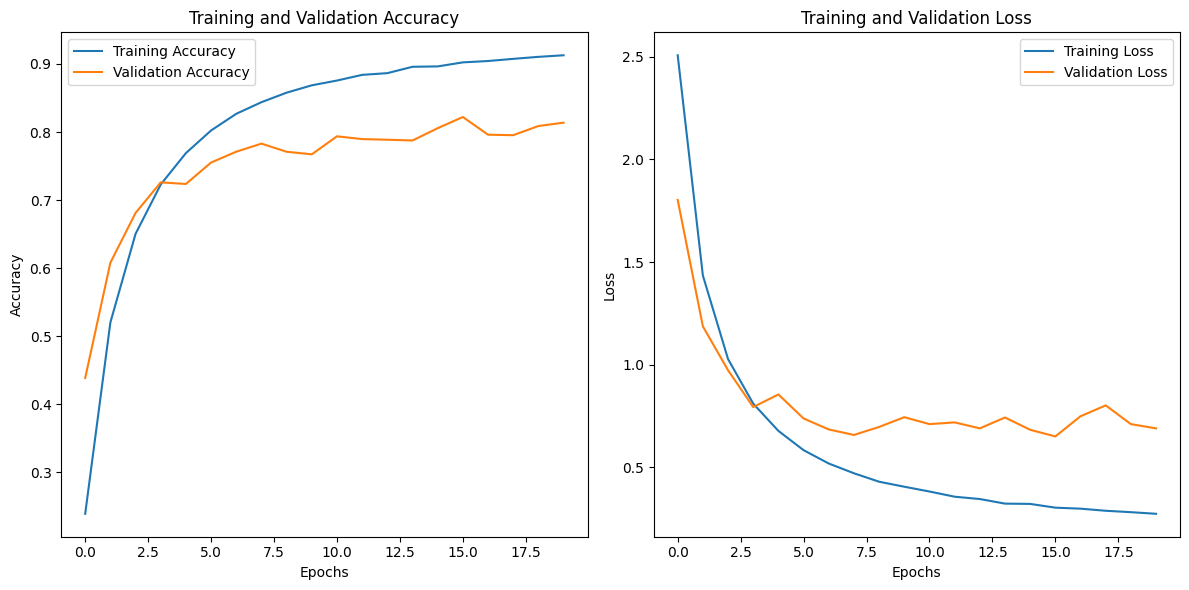

In [14]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

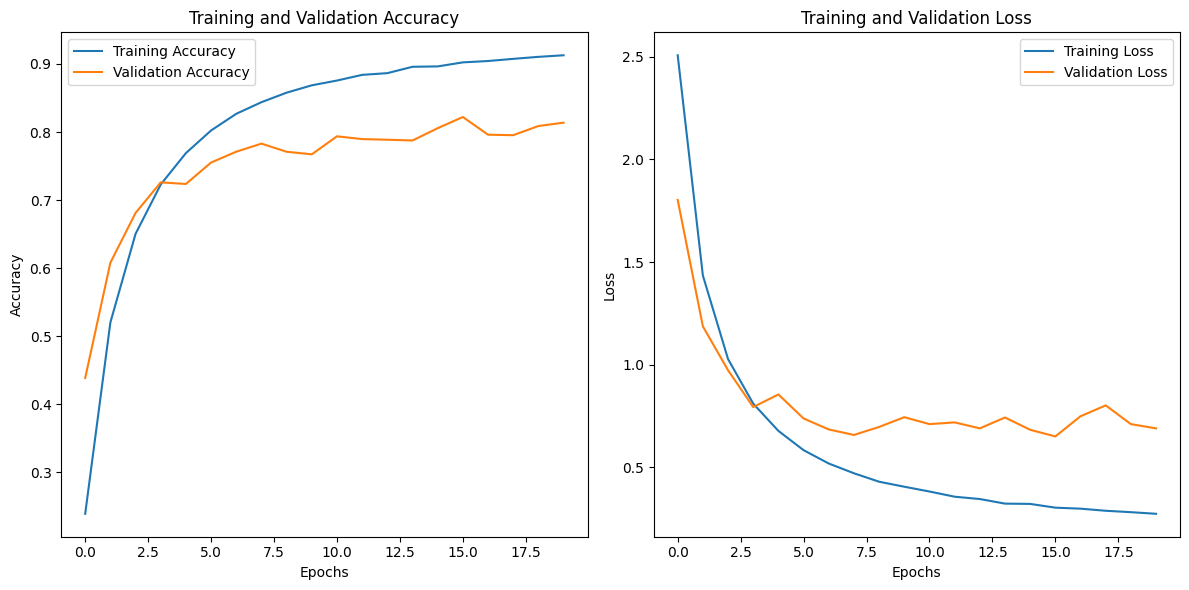

In [15]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()